In [ ]:
!wget http://mtg.upf.edu/static/datasets/last.fm/lastfm-dataset-360K.tar.gz

--2023-06-30 17:07:32--  http://mtg.upf.edu/static/datasets/last.fm/lastfm-dataset-360K.tar.gz
Resolving mtg.upf.edu (mtg.upf.edu)... 84.89.139.55
Connecting to mtg.upf.edu (mtg.upf.edu)|84.89.139.55|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 569202935 (543M) [application/octet-stream]
Saving to: ‘lastfm-dataset-360K.tar.gz’

lastfm-dataset-360K 100%[===================>] 542.83M  1.14MB/s    in 4m 38s  

2023-06-30 17:12:11 (1.95 MB/s) - ‘lastfm-dataset-360K.tar.gz’ saved [569202935/569202935]



In [ ]:
!tar -xzvf lastfm-dataset-360K.tar.gz

lastfm-dataset-360K/
lastfm-dataset-360K/usersha1-artmbid-artname-plays.tsv
lastfm-dataset-360K/README.txt
lastfm-dataset-360K/mbox_sha1sum.py
lastfm-dataset-360K/usersha1-profile.tsv


In [ ]:
!pip install implicit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 15.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook

import scipy.sparse as sparse

%matplotlib inline

from implicit.als import AlternatingLeastSquares

/usr/local/lib/python3.10/dist-packages/implicit/gpu/__init__.py:13: UserWarning: CUDA extension is built, but disabling GPU support because of 'Cuda Error: CUDA driver version is insufficient for CUDA runtime version (/project/./implicit/gpu/utils.h:71)'
  warnings.warn(


In [ ]:
raw_data = pd.read_table('./lastfm-dataset-360K/usersha1-artmbid-artname-plays.tsv', headers = False)

TypeError: ignored

In [ ]:
raw_data.head()

,00000c289a1829a808ac09c00daf10bc3c4e223b,3bd73256-3905-4f3a-97e2-8b341527f805,betty blowtorch,2137
0,00000c289a1829a808ac09c00daf10bc3c4e223b,f2fb0ff0-5679-42ec-a55c-15109ce6e320,die Ärzte,1099
1,00000c289a1829a808ac09c00daf10bc3c4e223b,b3ae82c2-e60b-4551-a76d-6620f1b456aa,melissa etheridge,897
2,00000c289a1829a808ac09c00daf10bc3c4e223b,3d6bbeb7-f90e-4d10-b440-e153c0d10b53,elvenking,717
3,00000c289a1829a808ac09c00daf10bc3c4e223b,bbd2ffd7-17f4-4506-8572-c1ea58c3f9a8,juliette & the licks,706
4,00000c289a1829a808ac09c00daf10bc3c4e223b,8bfac288-ccc5-448d-9573-c33ea2aa5c30,red hot chili peppers,691


In [ ]:
raw_data = raw_data.drop(raw_data.columns[1], axis=1)
raw_data.columns = ['user', 'artist', 'plays']

In [ ]:
raw_data.head()

,user,artist,plays
0,00000c289a1829a808ac09c00daf10bc3c4e223b,die Ärzte,1099
1,00000c289a1829a808ac09c00daf10bc3c4e223b,melissa etheridge,897
2,00000c289a1829a808ac09c00daf10bc3c4e223b,elvenking,717
3,00000c289a1829a808ac09c00daf10bc3c4e223b,juliette & the licks,706
4,00000c289a1829a808ac09c00daf10bc3c4e223b,red hot chili peppers,691


In [ ]:
data = raw_data.dropna()

In [ ]:
data.loc[[1,2]]

,user,artist,plays
1,00000c289a1829a808ac09c00daf10bc3c4e223b,melissa etheridge,897
2,00000c289a1829a808ac09c00daf10bc3c4e223b,elvenking,717


<Axes: >

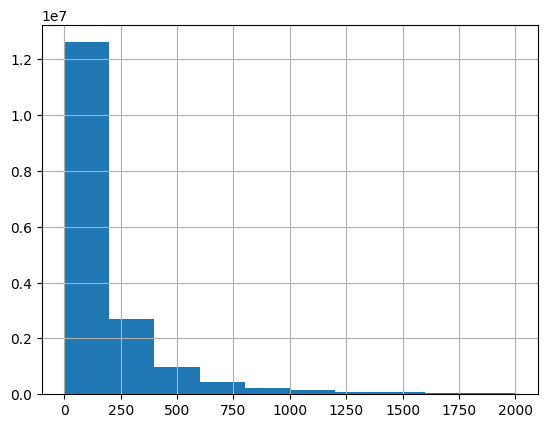

In [ ]:
data.iloc[np.where(data.plays < 2000)].plays.hist()

In [ ]:
data['user_id'] = data['user'].astype("category").cat.codes
data['artist_id'] = data['artist'].astype("category").cat.codes

<ipython-input-12-7c86c8603227>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['user_id'] = data['user'].astype("category").cat.codes
<ipython-input-12-7c86c8603227>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['artist_id'] = data['artist'].astype("category").cat.codes


In [ ]:
data.head()

,user,artist,plays,user_id,artist_id
0,00000c289a1829a808ac09c00daf10bc3c4e223b,die Ärzte,1099,0,90933
1,00000c289a1829a808ac09c00daf10bc3c4e223b,melissa etheridge,897,0,185367
2,00000c289a1829a808ac09c00daf10bc3c4e223b,elvenking,717,0,106704
3,00000c289a1829a808ac09c00daf10bc3c4e223b,juliette & the licks,706,0,155241
4,00000c289a1829a808ac09c00daf10bc3c4e223b,red hot chili peppers,691,0,220128


In [ ]:
item_lookup = data[['artist_id', 'artist']].drop_duplicates()
item_lookup['artist_id'] = item_lookup.artist_id.astype(str)

In [ ]:
item_lookup.head()

,artist_id,artist
0,90933,die Ärzte
1,185367,melissa etheridge
2,106704,elvenking
3,155241,juliette & the licks
4,220128,red hot chili peppers


In [ ]:
artist_id_name = {}

for index, row in tqdm_notebook(item_lookup.iterrows()):
    artist_id_name[row.artist_id] = row.artist

<ipython-input-16-d7e927a21f56>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for index, row in tqdm_notebook(item_lookup.iterrows()):


0it [00:00, ?it/s]

In [ ]:
data = data.drop(['user', 'artist'], axis=1)

In [ ]:
data.head()

,plays,user_id,artist_id
0,1099,0,90933
1,897,0,185367
2,717,0,106704
3,706,0,155241
4,691,0,220128


In [ ]:
data = data.loc[data.plays != 0]

In [ ]:
data.head()

,plays,user_id,artist_id
0,1099,0,90933
1,897,0,185367
2,717,0,106704
3,706,0,155241
4,691,0,220128


In [ ]:
users = list(np.sort(data.user_id.unique()))
artists = list(np.sort(data.artist_id.unique()))
plays = list(data.plays)

In [ ]:
users[:5]

[0, 1, 2, 3, 4]

In [ ]:
artists[:5]

[0, 1, 2, 3, 4]

In [ ]:
plays[:5]

[1099, 897, 717, 706, 691]

In [ ]:
len(users)

358868

In [ ]:
len(artists)

292363

In [ ]:
rows = data.user_id.astype(int)
cols = data.artist_id.astype(int)

In [ ]:
data_sparse = sparse.csr_matrix((plays, (cols, rows)), shape=(len(artists), len(users)))

In [ ]:
model = AlternatingLeastSquares(factors=50)
model.fit(data_sparse)

  0%|          | 0/15 [00:00<?, ?it/s]

In [ ]:
userid = 0

user_items = data_sparse.T.tocsr()
recommendations = model.recommend(userid, user_items)

ValueError: ignored

In [ ]:
recommendations

In [ ]:
for r in recommendations:
    print(artist_id_name[str(r[0])])

In [ ]:
itemid = 107209
related = model.similar_items(itemid)

In [ ]:
related

In [ ]:
for a in related:
    print(artist_id_name[str(a[0])])

In [ ]:
artist_id_name['234786']